In [72]:
import pandas as pd
df = pd.read_csv("datathon data/stock_data.csv")
df.columns

Index(['Date', 'Ticker_Symbol', 'Close_lag_1', 'Close_logreturn', 'Year',
       'Type', 'Type_Clean', 'Unit', 'Geography', 'Gas_Price', 'Month',
       'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Gas_Price_logreturn', 'Gas_Price_pct',
       'Brent_Price_logreturn', 'Brent_Price_pct', 'Refining_logreturn',
       'Refining_pct', 'Taxes_logreturn', 'Taxes_pct',
       'Distribution_and_Marketing_logreturn',
       'Distribution_and_Marketing_pct', 'Crude_Oil_logreturn',
       'Crude_Oil_pct', 'Gas_Price_lag_1'],
      dtype='object')

### Train XGBoost and Random Forest for each stock

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assume `df` is your full DataFrame with a 'Ticker_Symbol' column
label_col = 'Close_logreturn'
feature_cols = [
    col for col in df.columns
    if (
        col == 'Close_lag_1'
        # or col == 'Gas_Price_lag_1'
        or col == 'Brent_Price'
        or col == 'Gas_Price'
        or col == 'Stock_Number'
        or '_logreturn' in col
    )
    and col != label_col
]

print(feature_cols)

# Prepare a dict to hold per‐ticker results
results = {}

for symbol in df['Ticker_Symbol'].unique():
    # print(f"Processing {symbol}...")
    
    # 1) Subset the DataFrame to this ticker
    sub = df[df['Ticker_Symbol'] == symbol].copy()
    
    # 2) Extract X and y
    X = sub[feature_cols]
    y = sub[label_col]

    # 3) Standardize
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=X.columns
    )
    y_scaled = pd.Series(
        scaler.fit_transform(y.values.reshape(-1, 1)).ravel(),
        index=y.index,
        name=y.name
    )

    # print(X)
    # print(y)
    
    # 4) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    # 5) Fit model
    model = XGBRegressor(random_state = 42, n_estimators=50, learning_rate=0.1, max_depth=5)

    model.fit(X_train, y_train)
    
    # 6) Predict & evaluate
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    
    # 7) Feature importances
    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 8) Store results
    results[symbol] = {
        'model': model,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'feature_importances': feat_imp
    }

print(f"Processing {symbol}...")

# Accessing results for e.g. ticker "HAL":
print("HAL train MSE:", results['HAL']['mse_train'])
print("HAL test MSE:",  results['HAL']['mse_test'])
print("HAL top features:\n", results['HAL']['feature_importances'].head())


['Close_lag_1', 'Gas_Price', 'Brent_Price', 'Gas_Price_logreturn', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
Processing SPY...
HAL train MSE: 0.4500874020169973
HAL test MSE: 1.0512767243772465
HAL top features:
                                 feature  importance
4                 Brent_Price_logreturn    0.183312
8                   Crude_Oil_logreturn    0.130643
5                    Refining_logreturn    0.127000
7  Distribution_and_Marketing_logreturn    0.121891
6                       Taxes_logreturn    0.116177


HAL train MSE: 0.4500874020169973
HAL test MSE: 1.0512767243772465


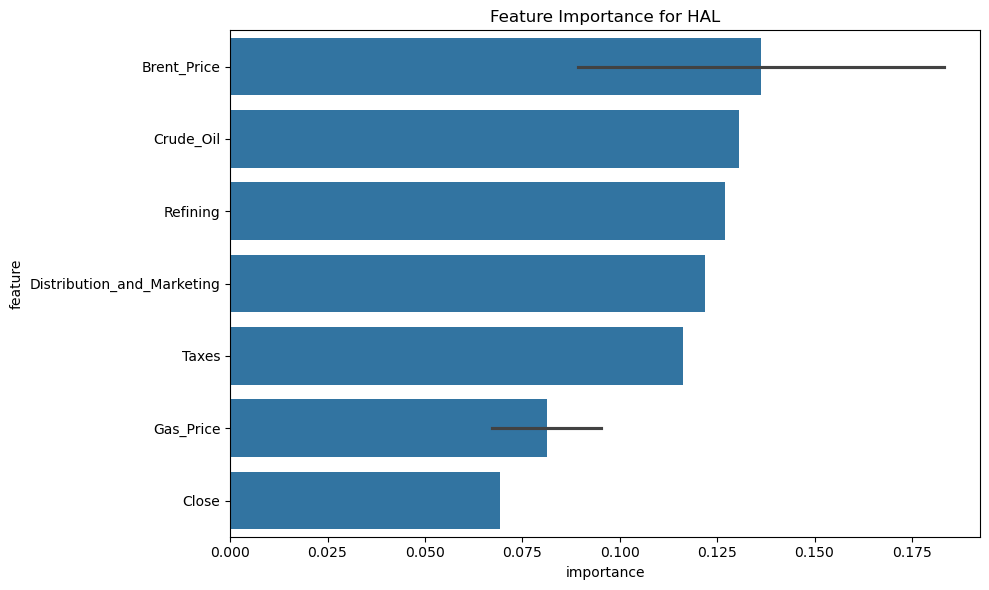

FANG train MSE: 0.3275398285967745
FANG test MSE: 1.452856861627044


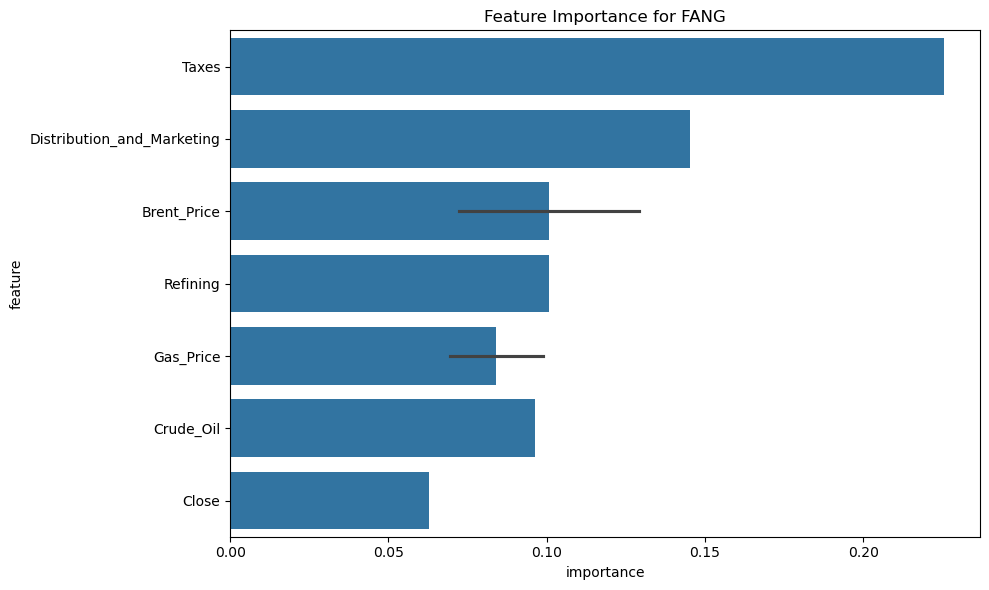

E train MSE: 0.14120593072280418
E test MSE: 1.7865080290258362


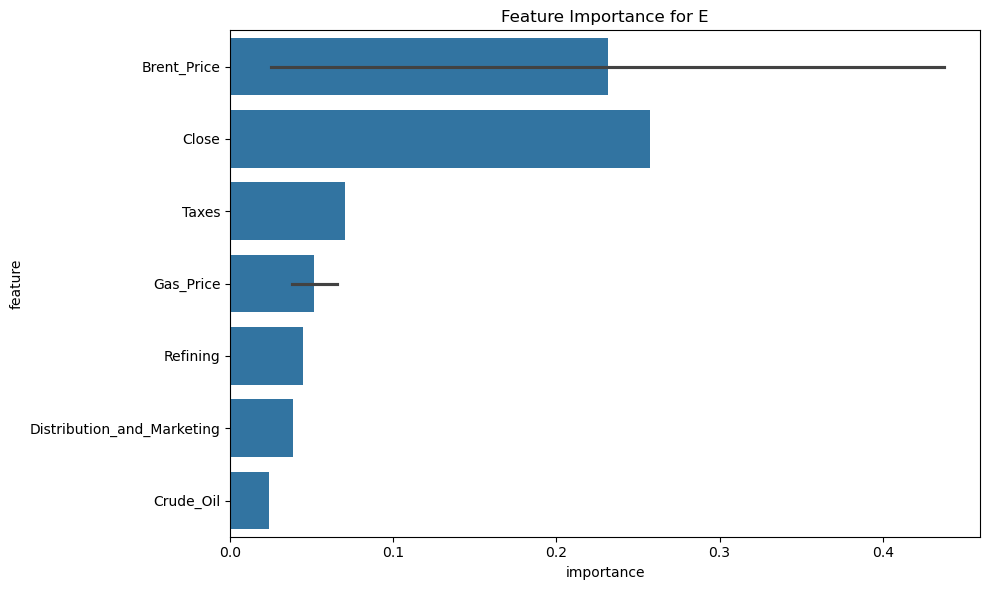

EXC train MSE: 0.3725024796879969
EXC test MSE: 1.2046659346943231


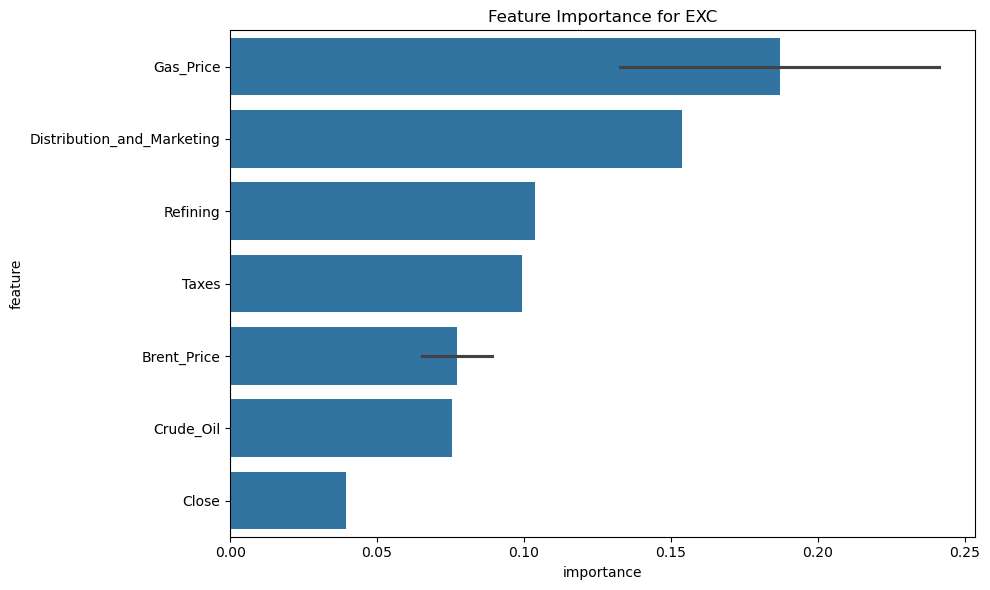

HES train MSE: 0.40040590911414886
HES test MSE: 1.15061842334587


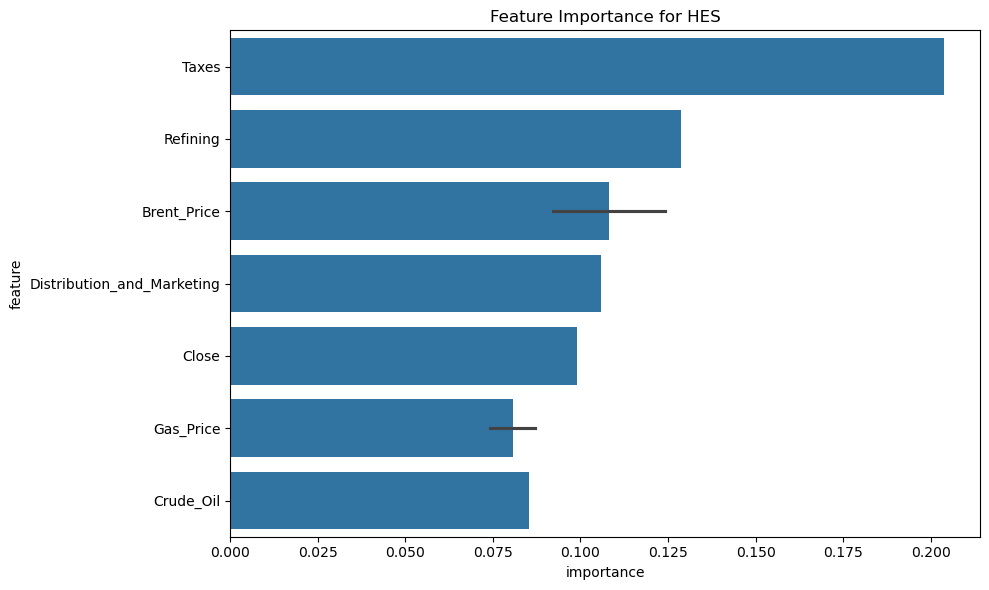

BKR train MSE: 0.17430575902768564
BKR test MSE: 1.9608066538948998


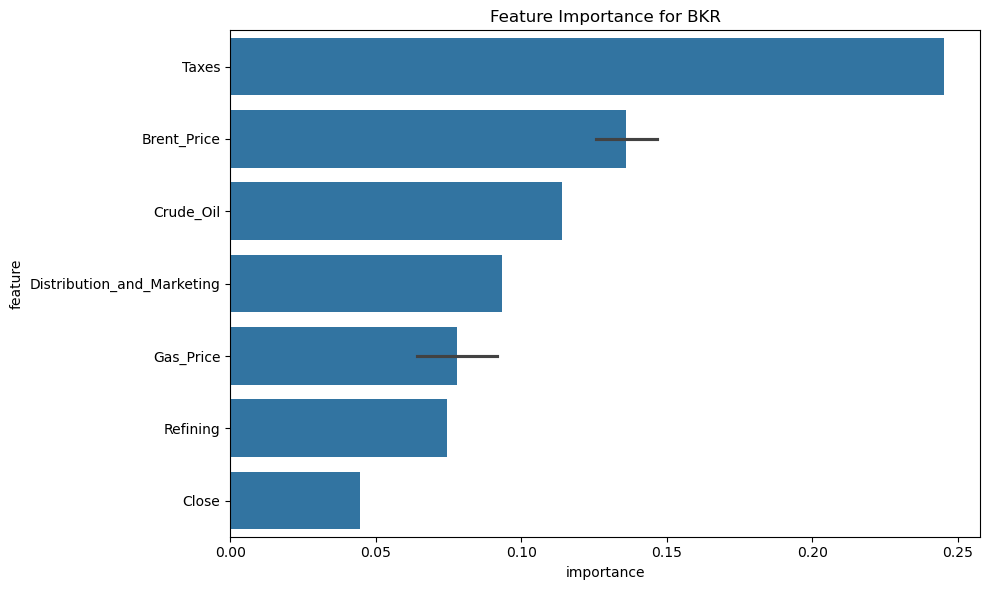

BPT train MSE: 0.373632679158045
BPT test MSE: 1.1844195405870022


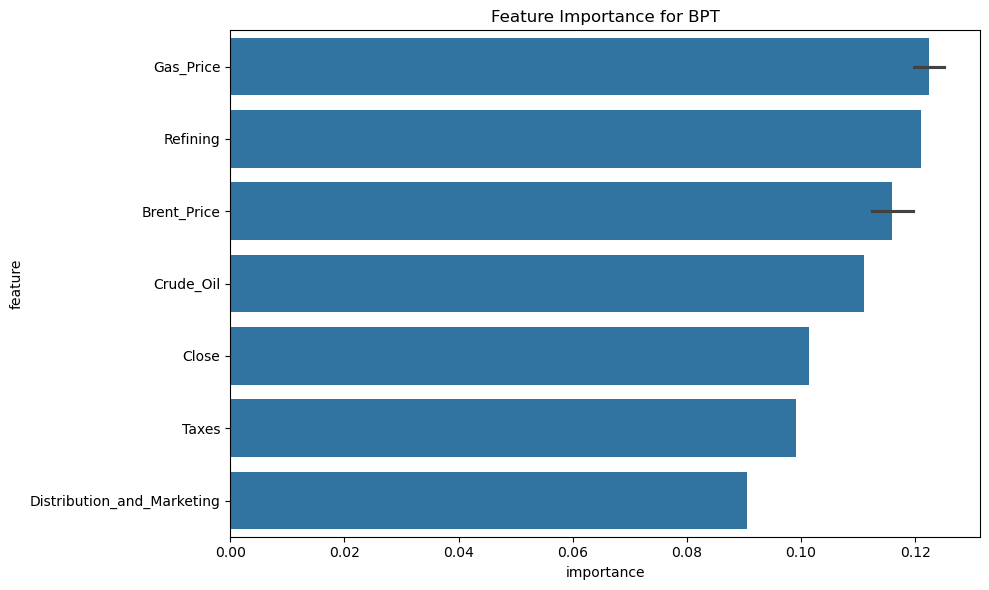

VLO train MSE: 0.5144336055596713
VLO test MSE: 1.1576915902664284


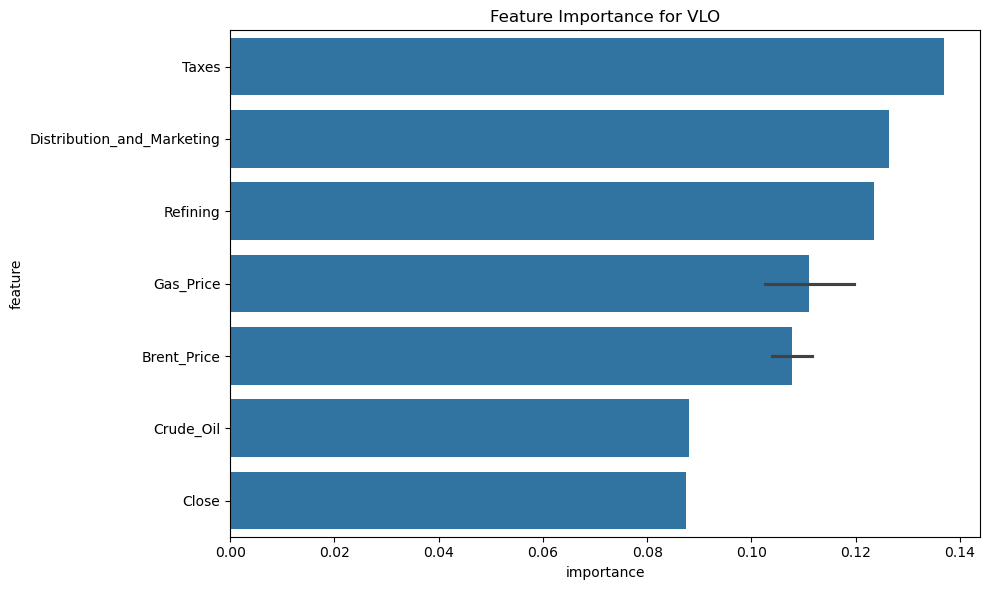

CVX train MSE: 0.41998426807710276
CVX test MSE: 1.055485135518818


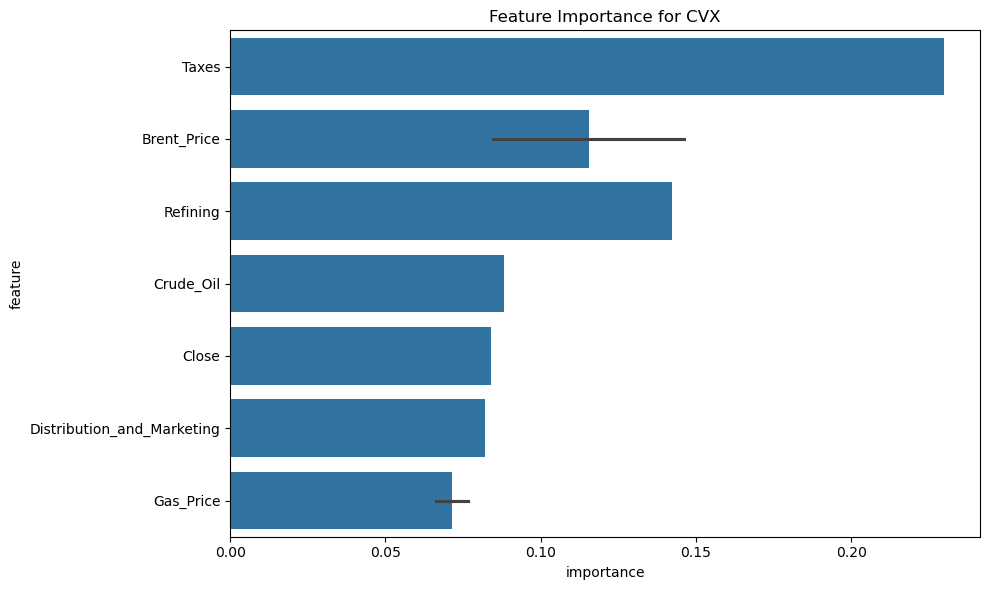

OXY train MSE: 0.4203102175931193
OXY test MSE: 1.1462619298372183


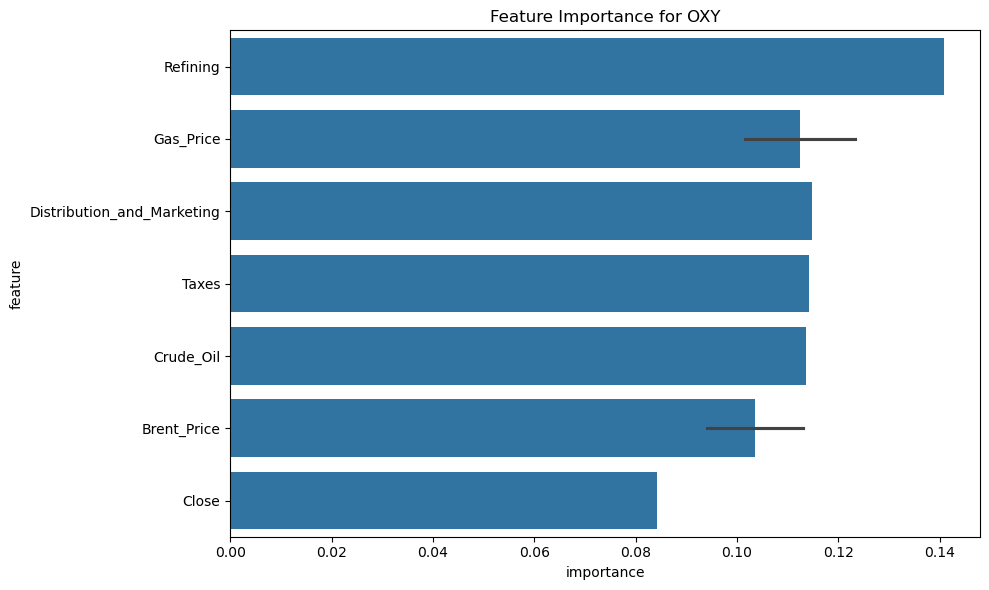

KMI train MSE: 0.3359678007183821
KMI test MSE: 1.3518059882699978


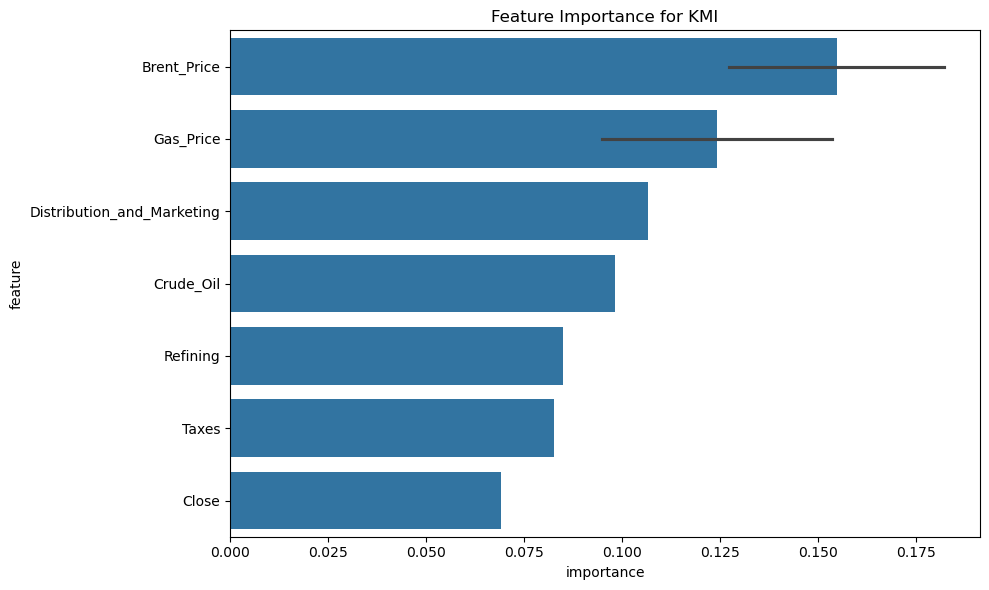

PSX train MSE: 0.3215579588026194
PSX test MSE: 1.422285192019317


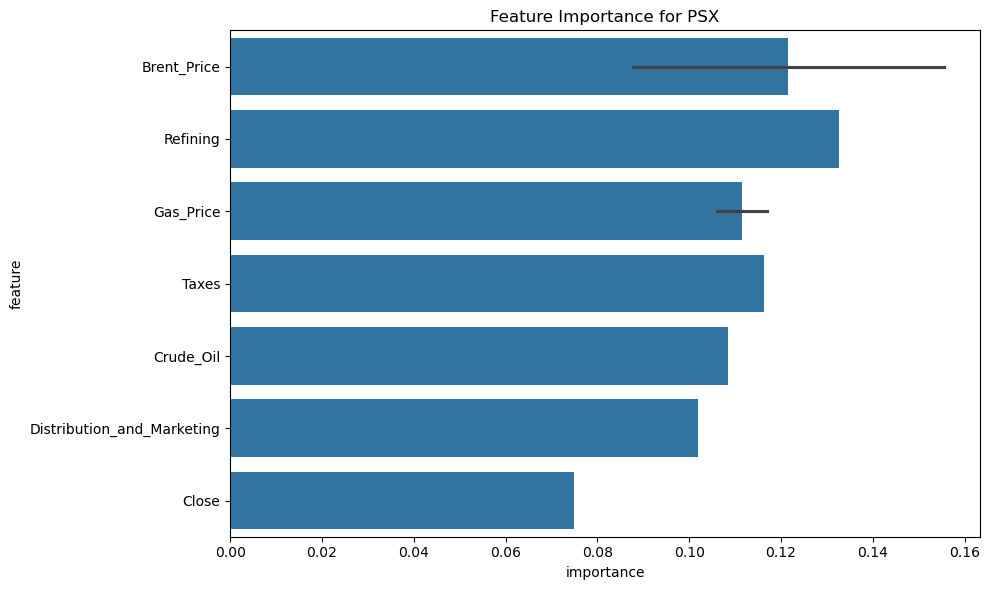

NOV train MSE: 0.45714224274793525
NOV test MSE: 1.1809607988163893


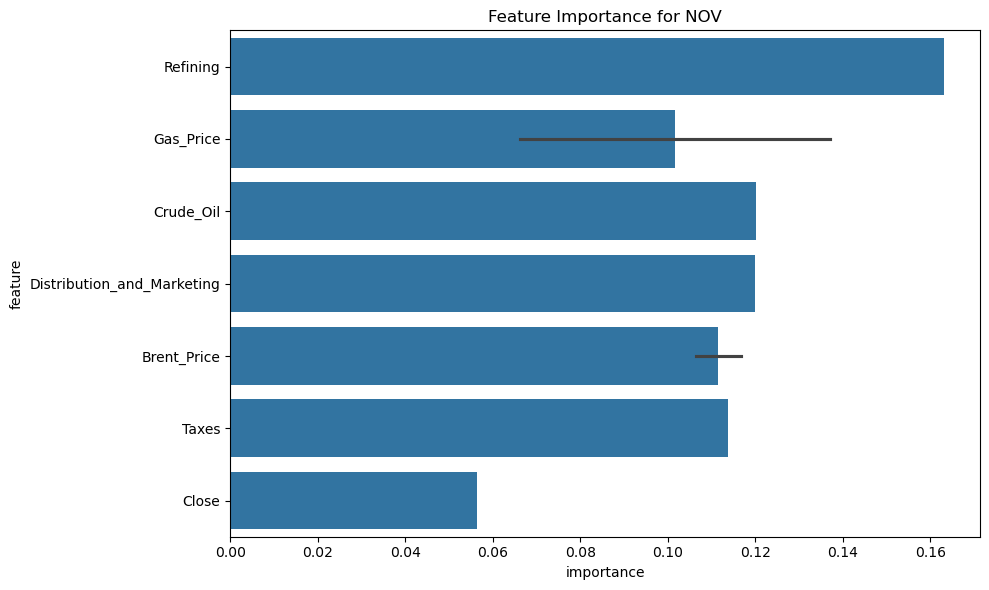

CHK train MSE: 0.05433580680216134
CHK test MSE: 1.0724763714492858


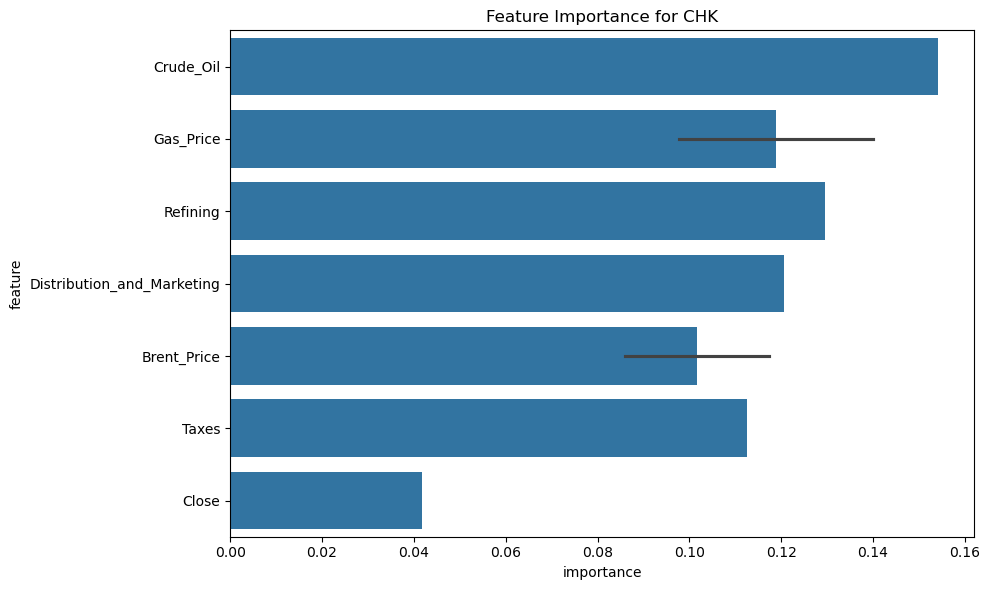

MPC train MSE: 0.2873660437547626
MPC test MSE: 1.1043661446229025


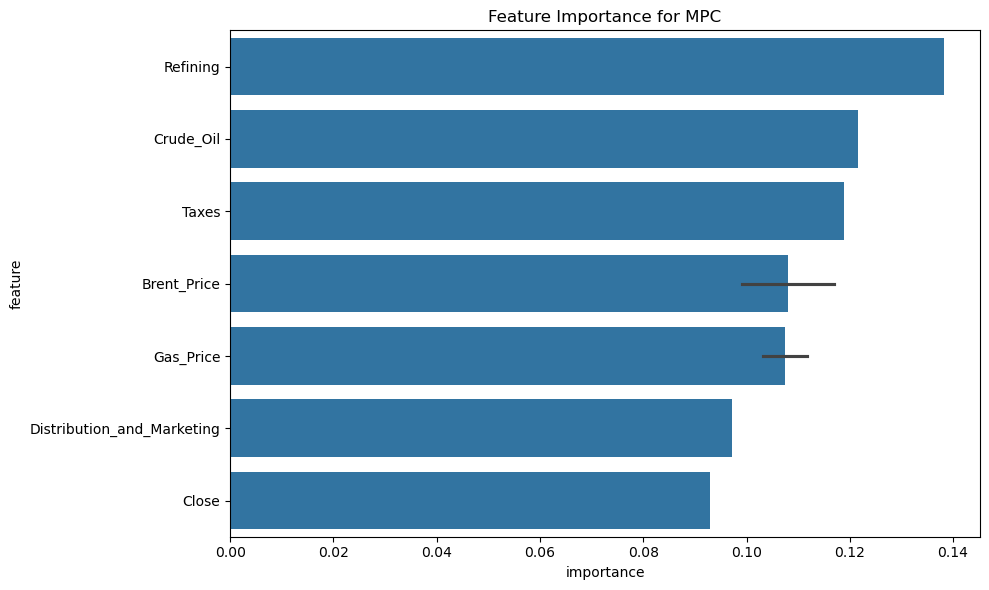

DVN train MSE: 0.2668327295360507
DVN test MSE: 0.8478281361219789


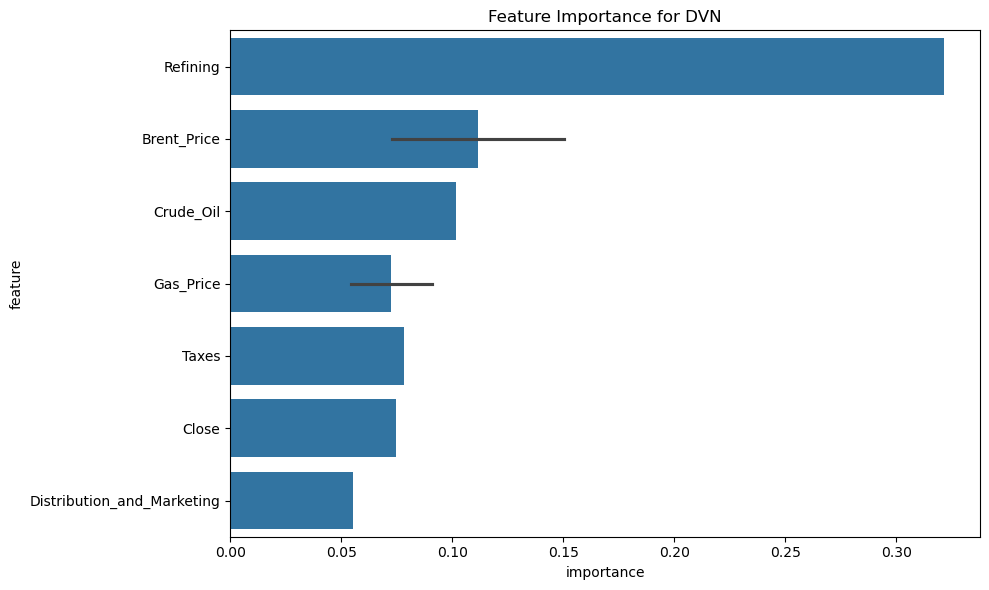

COP train MSE: 0.386722591590616
COP test MSE: 1.0358670755865151


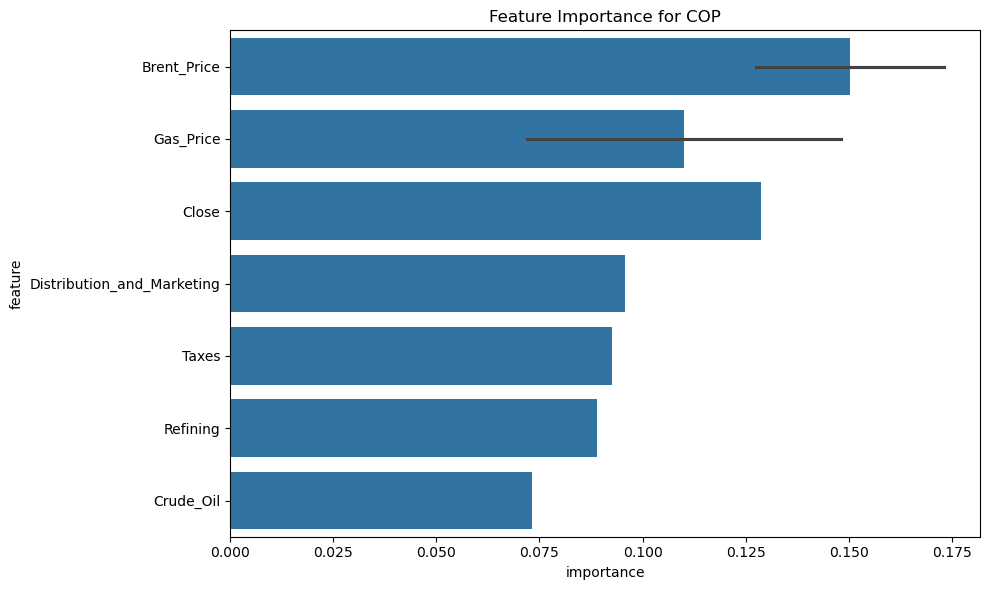

EPD train MSE: 0.4354194606886822
EPD test MSE: 1.058949568090396


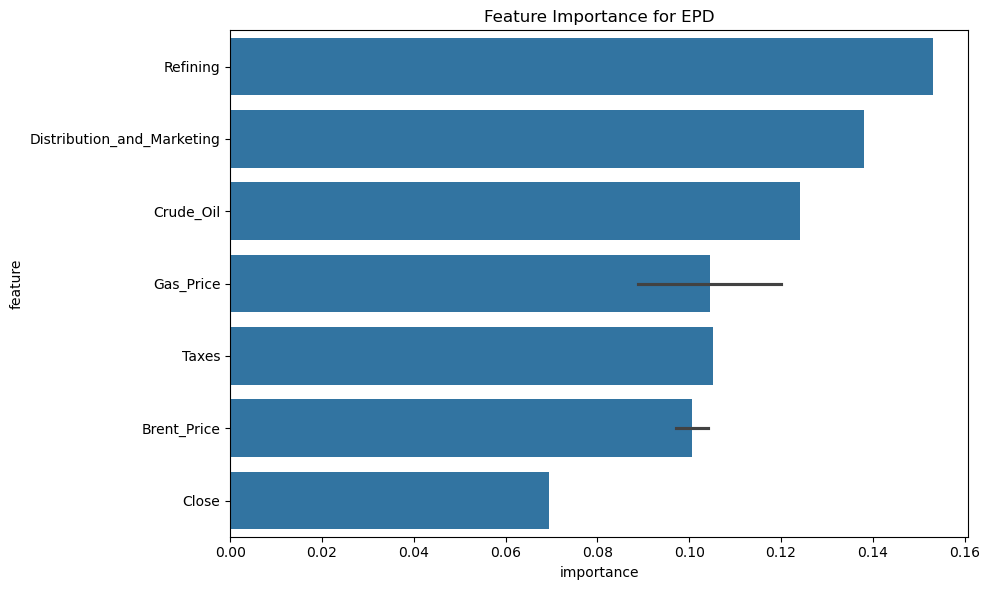

BP train MSE: 0.37737234462471847
BP test MSE: 1.074356256540641


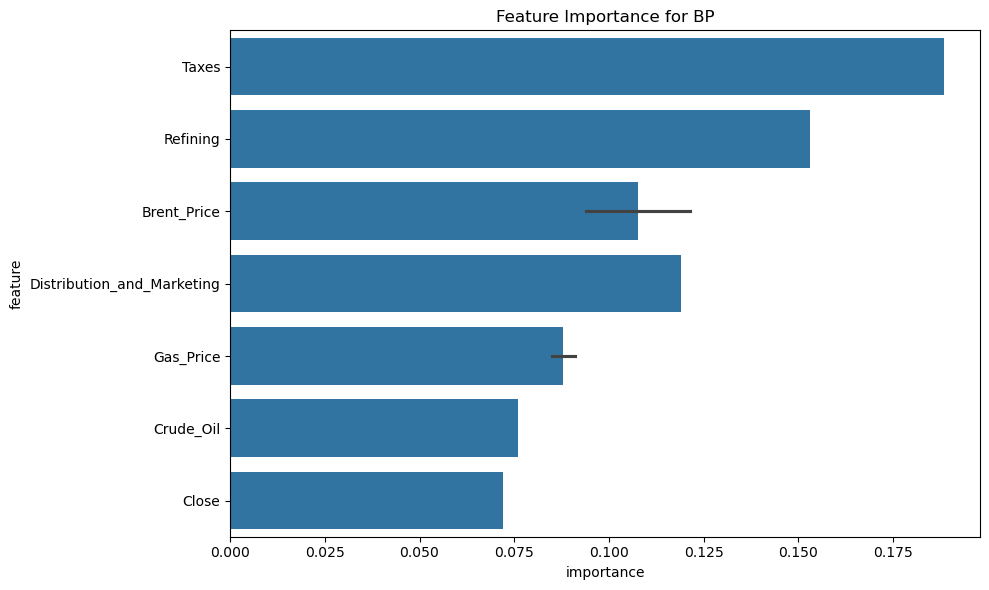

XOM train MSE: 0.4619869269769741
XOM test MSE: 1.3224352148161993


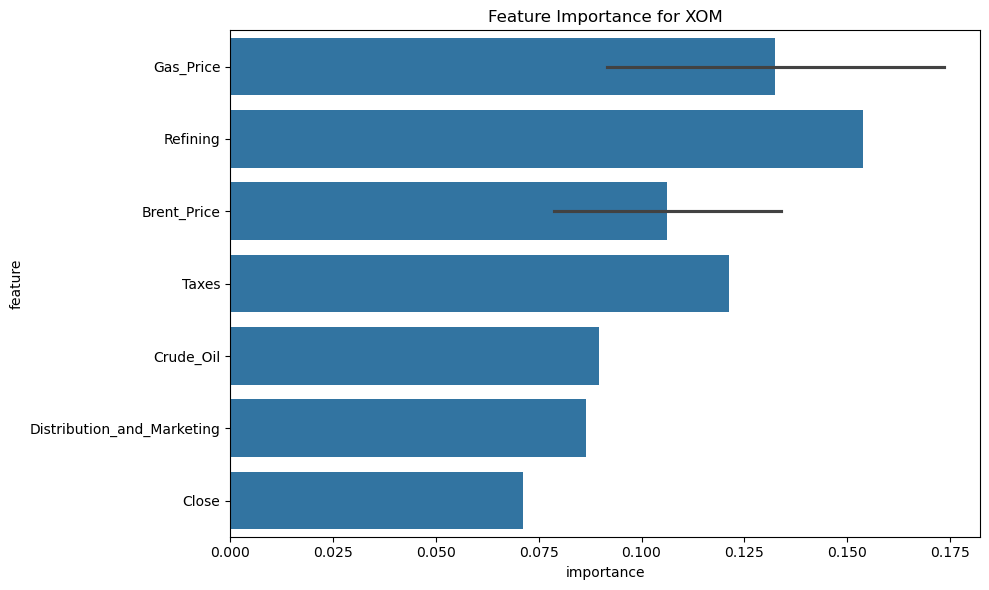

EOG train MSE: 0.22284375543600185
EOG test MSE: 2.8710292739894197


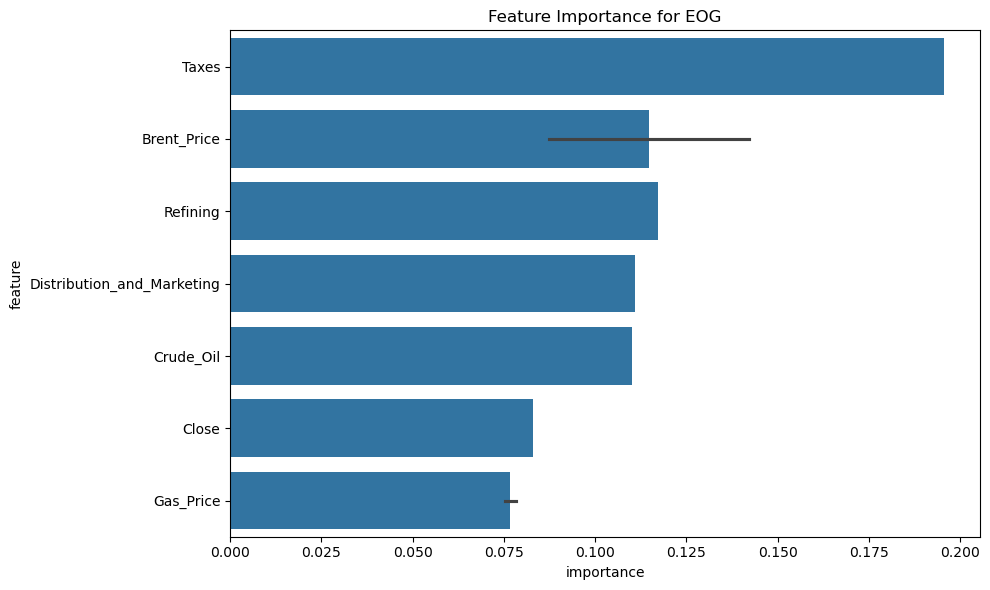

CEO train MSE: 0.4365914888701537
CEO test MSE: 1.0393979514370666


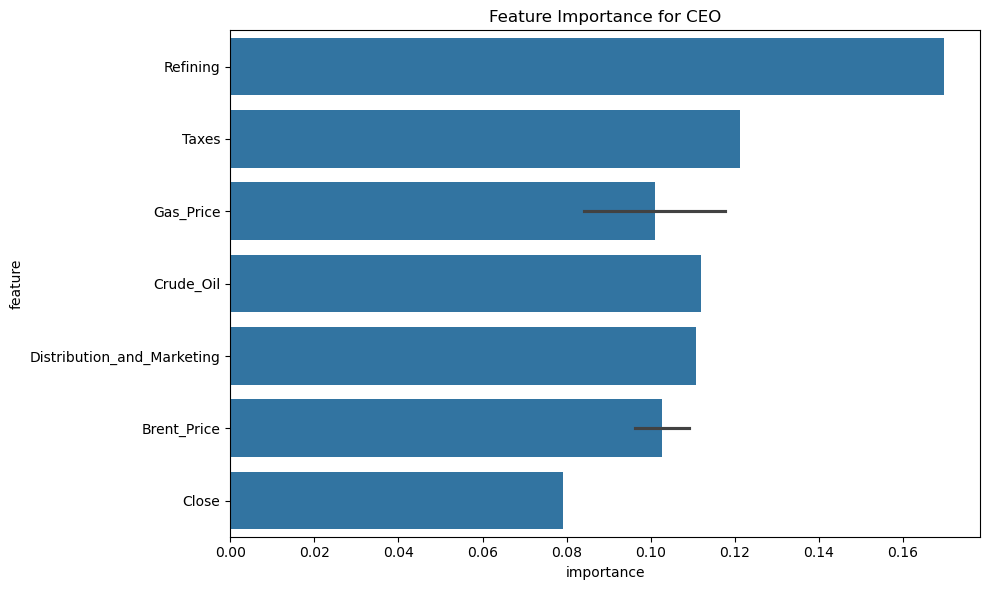

SLB train MSE: 0.4289192596809385
SLB test MSE: 1.1089680945642213


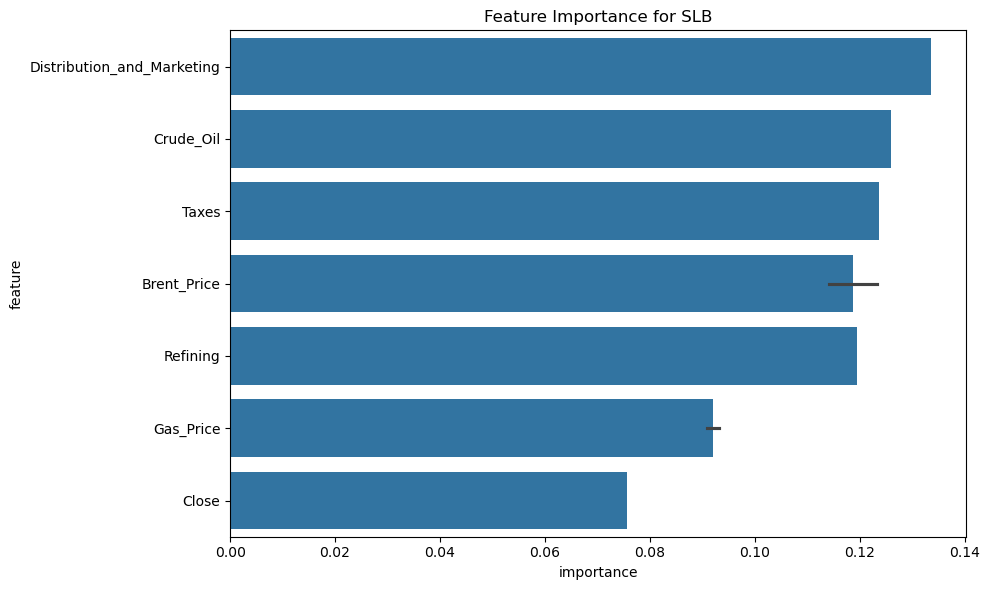

WMB train MSE: 0.23850244180378377
WMB test MSE: 1.8881297469696579


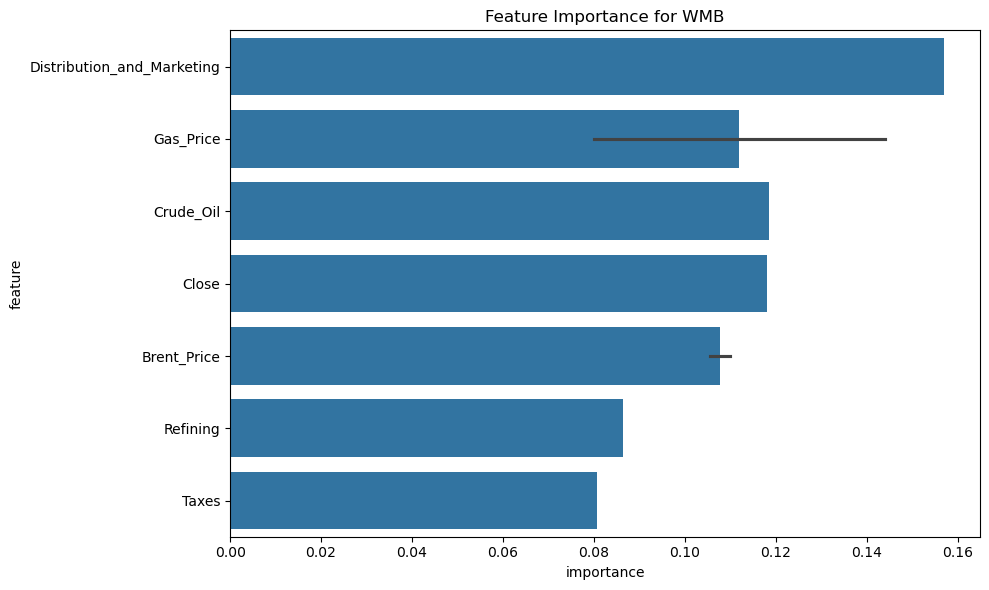

ONEQ train MSE: 0.4250502129643993
ONEQ test MSE: 0.9496755756922372


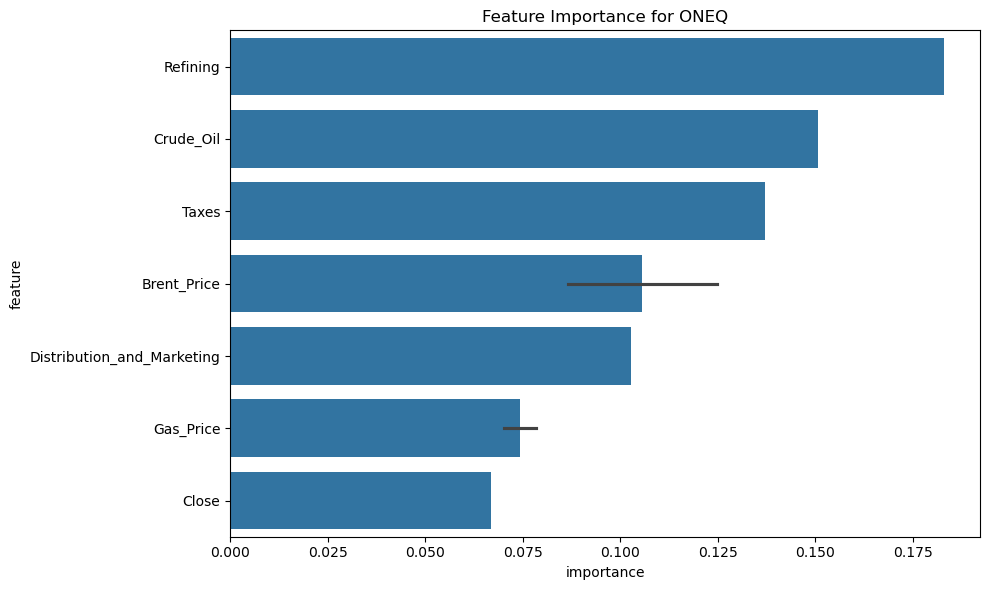

DIA train MSE: 0.37649183636052347
DIA test MSE: 1.2548686407517375


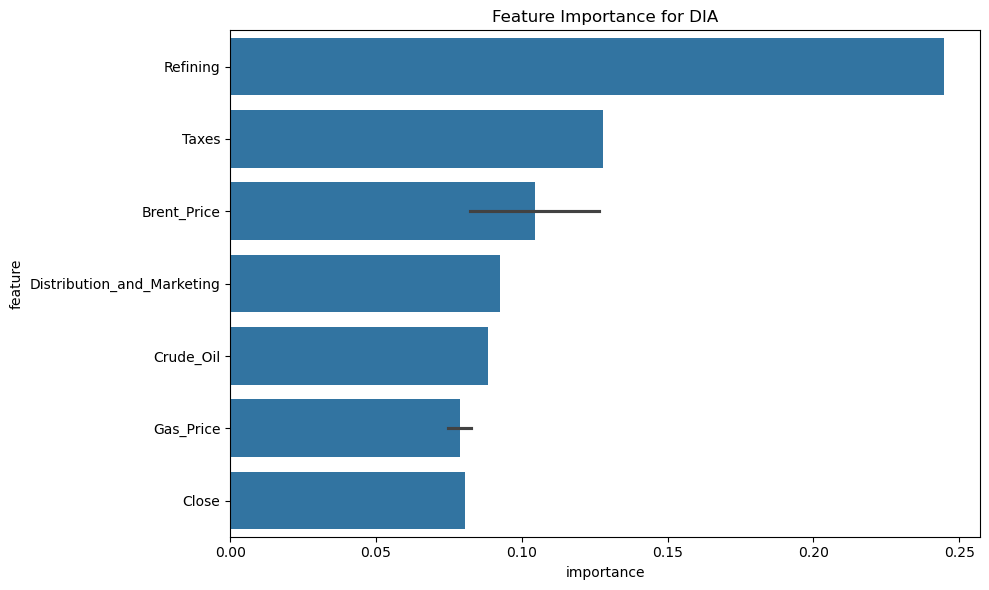

VOO train MSE: 0.33539288246213195
VOO test MSE: 0.9086814266165473


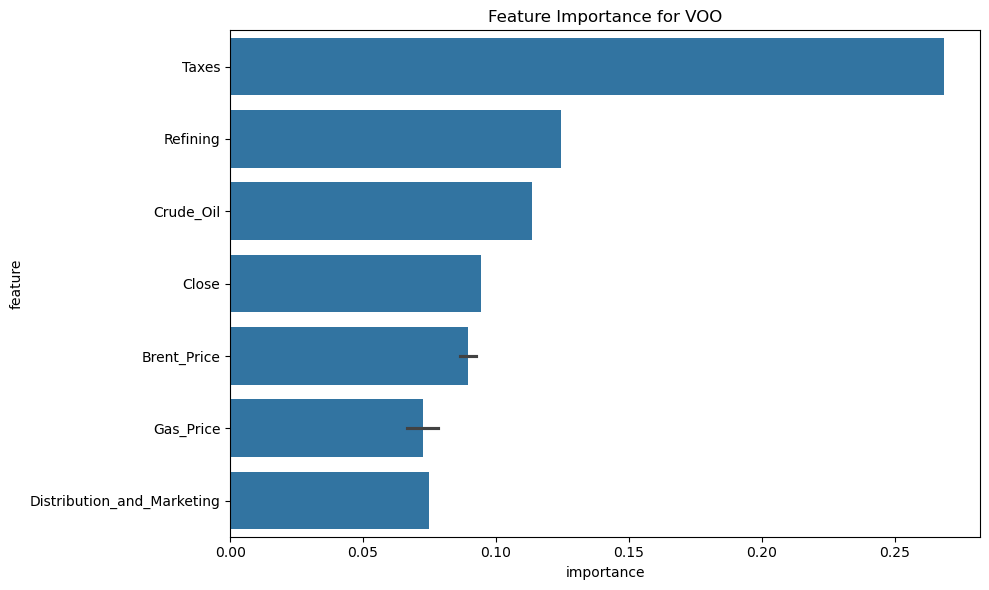

SPY train MSE: 0.42419562583723874
SPY test MSE: 1.2287222592638405


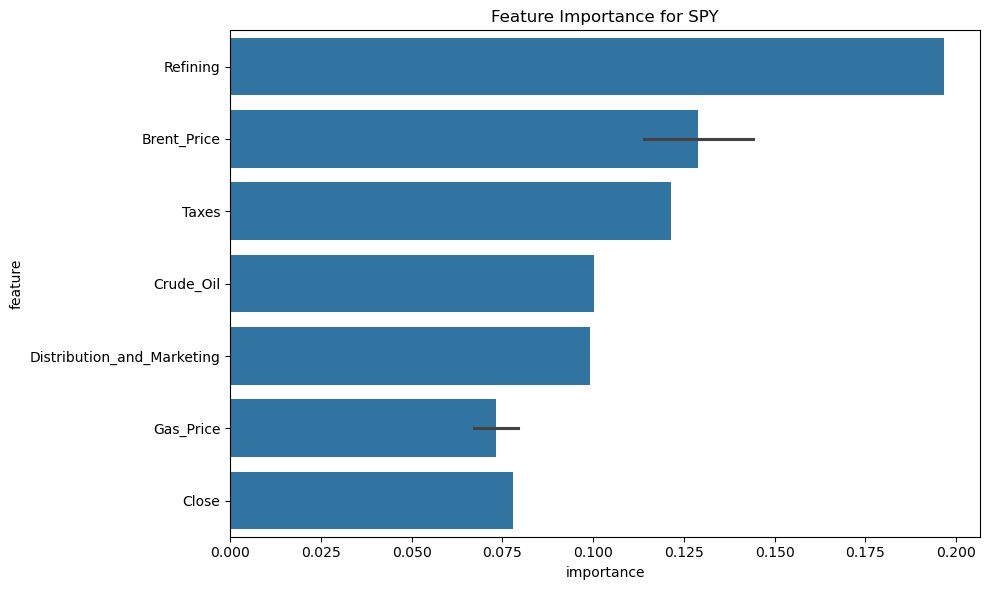

In [74]:
from matplotlib import pyplot as plt
import seaborn as sns
for symbol in df['Ticker_Symbol'].unique():
    print(f"{symbol} train MSE:", results[symbol]['mse_train'])
    print(f"{symbol} test MSE:",  results[symbol]['mse_test'])
    
    feat_importance = results[symbol]['feature_importances']
    feat_importance['feature'] = feat_importance['feature'].str.replace('_logreturn', '')
    feat_importance['feature'] = feat_importance['feature'].str.replace('Close_lag_1', 'Close')
    feat_importance['feature'] = feat_importance['feature'].str.replace('Stock_Number', 'Stock Number')
    feat_importance['feature'] = feat_importance['feature'].str.replace('logreturn', 'Log Return')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_importance)
    plt.title(f"Feature Importance for {symbol}")
    plt.tight_layout()
    plt.show()

In [75]:
# 1. Gather all unique features
features = results[next(iter(results))]['feature_importances']['feature'].tolist()

# 2. Initialize an empty DataFrame
imp_matrix = pd.DataFrame(
    index=results.keys(),
    columns=features,
    data=0.0
)

# 3. Fill in importances
for symbol, res in results.items():
    fi = res['feature_importances'].set_index('feature')
    for feat, val in fi['importance'].items():
        imp_matrix.loc[symbol, feat] = val
# for symbol, res in results.items():
#     fi = res['feature_importances']
#     imp_matrix.loc[symbol, fi['feature']] = fi['importance'].values

imp_matrix

,Brent_Price,Crude_Oil,Refining,Distribution_and_Marketing,Taxes,Gas_Price,Brent_Price,Close,Gas_Price
HAL,0.089383,0.130643,0.127000,0.121891,0.116177,0.067215,0.089383,0.069184,0.067215
FANG,0.072136,0.096291,0.100557,0.145295,0.225551,0.069447,0.072136,0.062876,0.069447
E,0.024928,0.023672,0.044393,0.038382,0.070110,0.037812,0.024928,0.257576,0.037812
EXC,0.065407,0.075355,0.103658,0.153574,0.099322,0.132731,0.065407,0.039509,0.132731
HES,0.092129,0.085296,0.128701,0.105783,0.203852,0.074161,0.092129,0.099035,0.074161
BKR,0.125684,0.114027,0.074567,0.093560,0.245367,0.064133,0.125684,0.044512,0.064133
BPT,0.112379,0.110985,0.120942,0.090586,0.099101,0.119826,0.112379,0.101420,0.119826
VLO,0.103933,0.087963,0.123526,0.126333,0.137003,0.102514,0.103933,0.087486,0.102514
CVX,0.084521,0.088213,0.142310,0.082021,0.229912,0.066159,0.084521,0.084035,0.066159
OXY,0.094133,0.113633,0.140912,0.114749,0.114239,0.101679,0.094133,0.084322,0.101679


In [76]:
import pandas as pd

types_df = pd.read_excel("datathon data/stock_descriptions_class.xlsx")

# Save as CSV
types_df.to_csv("datathon data/stock_descriptions_class.csv", index=False)
types_df.rename(columns={'Symbol': 'Ticker_Symbol'}, inplace=True)
types_df

,Ticker_Symbol,AssetType,Name,Description,Sector,Industry,chain
0,BKR,Common Stock,Baker Hughes Company,Baker Hughes Company provides a portfolio of t...,ENERGY & TRANSPORTATION,OIL & GAS EQUIPMENT & SERVICES,upstream*
1,BP,Common Stock,BP PLC ADR,BP plc participates in the energy business glo...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,downstream*
2,BPT,Common Stock,BP Prudhoe Bay Royalty Trust,BP Prudhoe Bay Royalty Trust is a grantor trus...,TECHNOLOGY,GENERAL,upstream
3,CEO,Common Stock,CNOOC Limited,CNOOC Limited operates exploration and product...,ENERGY & TRANSPORTATION,OIL & GAS EQUIPMENT & SERVICES,upstream
4,CHK,Common Stock,Chesapeake Energy Corporation,"Chesapeake Energy Corporation, an independent ...",ENERGY & TRANSPORTATION,OIL & GAS EQUIPMENT & SERVICES,upstream
5,COP,Common Stock,ConocoPhillips,ConocoPhillips is an American multinational co...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,upstream
6,CVX,Common Stock,Chevron Corp,Chevron Corporation is an American multination...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,integrated
7,DVN,Common Stock,Devon Energy Corporation,Devon Energy Corporation is an American energy...,ENERGY & TRANSPORTATION,CRUDE PETROLEUM & NATURAL GAS,upstream
8,E,Common Stock,Eni S.p.A,Eni S.p.A. operates as an integrated energy co...,ENERGY & TRANSPORTATION,OIL & GAS INTEGRATED,integrated
9,EOG,Common Stock,EOG Resources Inc,"EOG Resources, Inc. is an American energy comp...",ENERGY & TRANSPORTATION,CRUDE PETROLEUM & NATURAL GAS,upstream


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# 1) Create 2D embedding via PCA for visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(imp_matrix)
emb_df = pd.DataFrame(coords, index=imp_matrix.index, columns=['PC1', 'PC2'])
emb_df['Ticker_Symbol'] = emb_df.index
emb_df

,PC1,PC2,Ticker_Symbol
HAL,0.006794,-0.005160,HAL
FANG,-0.071393,0.067107,FANG
E,-0.104140,-0.203318,E
EXC,-0.001326,-0.022505,EXC
HES,-0.046489,0.036891,HES
BKR,-0.093077,0.095612,BKR
BPT,0.004567,-0.038895,BPT
VLO,-0.013599,-0.004819,VLO
CVX,-0.043792,0.064696,CVX
OXY,0.016064,-0.014346,OXY


KMeans silhouette score: 0.263


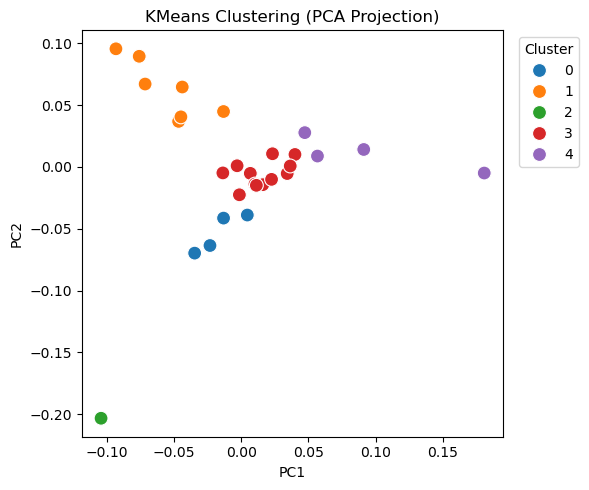

Agglomerative silhouette score: 0.263


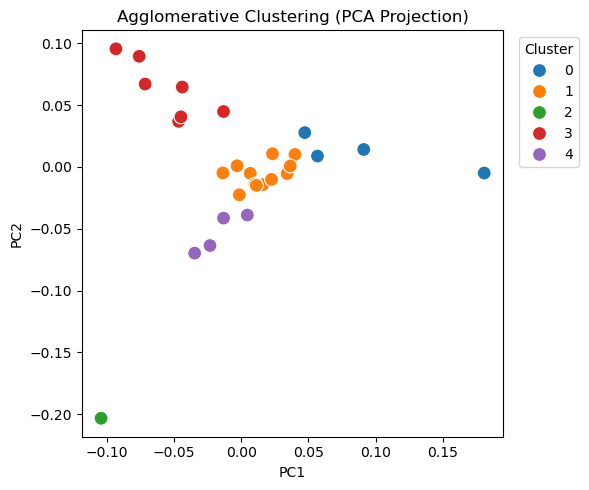

In [78]:
# 2) Define clustering algorithms
k = 5
methods = {
    'KMeans':            KMeans(n_clusters=k, random_state=42,),
    'Agglomerative':     AgglomerativeClustering(n_clusters=k, linkage='ward'),
}

# 3) Run clustering, plot
for name, algo in methods.items():
    labels = algo.fit_predict(imp_matrix)
    emb_df[name] = labels

    # Silhouette score
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:
        score = silhouette_score(imp_matrix, labels)
        print(f"{name} silhouette score: {score:.3f}")
    else:
        print(f"{name} produced {len(unique_labels)} clusters (including noise).")

    # Scatterplot in PCA space
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=emb_df,
        x='PC1', y='PC2',
        hue=name,
        palette='tab10',
        s=100,
        legend='full'
    )
    plt.title(f"{name} Clustering (PCA Projection)")
    plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

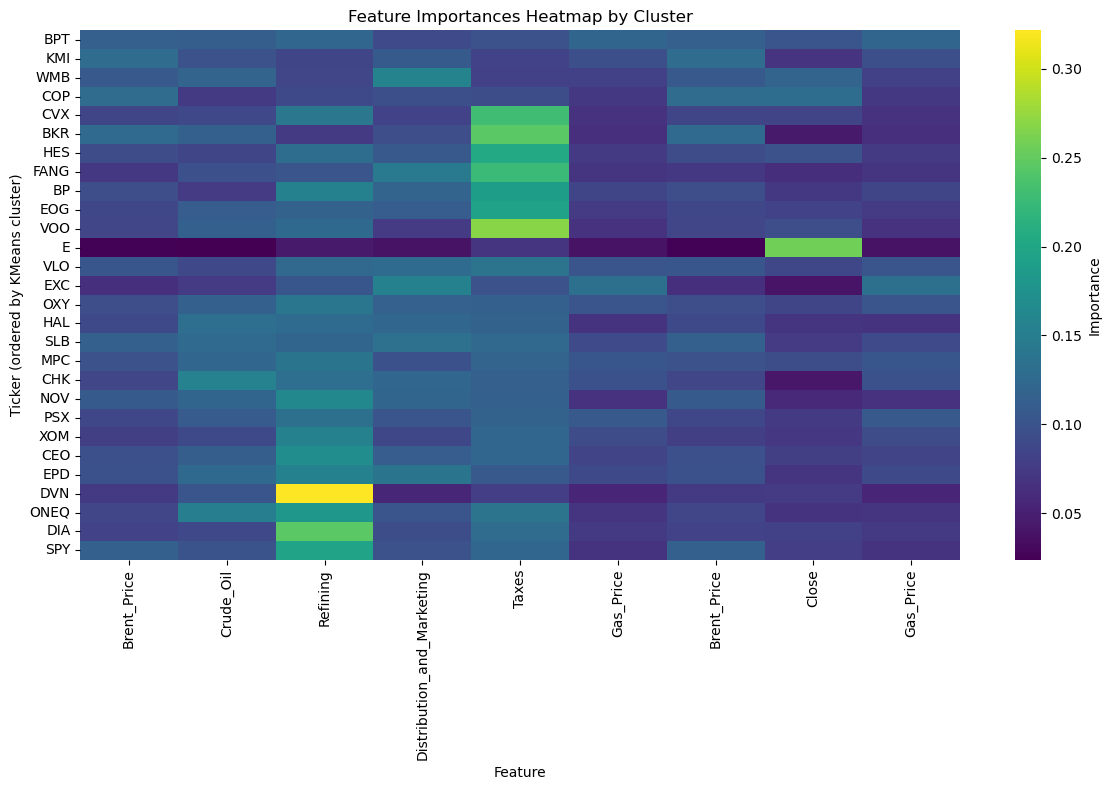

In [79]:
# 4) Heatmap of feature importances ordered by one cluster labeling
order = emb_df.sort_values('KMeans').index
plt.figure(figsize=(12,8))
sns.heatmap(
    imp_matrix.loc[order],
    cmap='viridis',
    cbar_kws={'label': 'Importance'},
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Feature")
plt.ylabel("Ticker (ordered by KMeans cluster)")
plt.title("Feature Importances Heatmap by Cluster")
plt.tight_layout()
plt.show()

In [80]:
for name in methods.keys():
    print(f"\n=== {name} cluster assignments ===")
    labels = emb_df[name]
    for cluster_label in sorted(labels.unique()):
        members = labels[labels == cluster_label].index.tolist()
        print(f"Cluster {cluster_label}: {members}")



=== KMeans cluster assignments ===
Cluster 0: ['BPT', 'KMI', 'COP', 'WMB']
Cluster 1: ['FANG', 'HES', 'BKR', 'CVX', 'BP', 'EOG', 'VOO']
Cluster 2: ['E']
Cluster 3: ['HAL', 'EXC', 'VLO', 'OXY', 'PSX', 'NOV', 'CHK', 'MPC', 'EPD', 'XOM', 'CEO', 'SLB']
Cluster 4: ['DVN', 'ONEQ', 'DIA', 'SPY']

=== Agglomerative cluster assignments ===
Cluster 0: ['DVN', 'ONEQ', 'DIA', 'SPY']
Cluster 1: ['HAL', 'EXC', 'VLO', 'OXY', 'PSX', 'NOV', 'CHK', 'MPC', 'EPD', 'XOM', 'CEO', 'SLB']
Cluster 2: ['E']
Cluster 3: ['FANG', 'HES', 'BKR', 'CVX', 'BP', 'EOG', 'VOO']
Cluster 4: ['BPT', 'KMI', 'COP', 'WMB']


In [81]:
merged = pd.merge(emb_df, types_df, on='Ticker_Symbol', how='left')
merged

,PC1,PC2,Ticker_Symbol,KMeans,Agglomerative,AssetType,Name,Description,Sector,Industry,chain
0,0.006794,-0.005160,HAL,3,1,Common Stock,Halliburton Company,Halliburton Company is an American multination...,ENERGY & TRANSPORTATION,"OIL & GAS FIELD SERVICES, NEC",upstream
1,-0.071393,0.067107,FANG,1,3,Common Stock,"Diamondback Energy, Inc.","Diamondback Energy, Inc., an independent oil a...",ENERGY & TRANSPORTATION,OIL & GAS E&P,upstream
2,-0.104140,-0.203318,E,2,2,Common Stock,Eni S.p.A,Eni S.p.A. operates as an integrated energy co...,ENERGY & TRANSPORTATION,OIL & GAS INTEGRATED,integrated
3,-0.001326,-0.022505,EXC,3,1,Common Stock,Exelon Corporation,Exelon Corporation is an American Fortune 100 ...,ENERGY & TRANSPORTATION,ELECTRIC & OTHER SERVICES COMBINED,downstream
4,-0.046489,0.036891,HES,1,3,Common Stock,Hess Corporation,Hess Corporation (formerly Amerada Hess Corpor...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,upstream
5,-0.093077,0.095612,BKR,1,3,Common Stock,Baker Hughes Company,Baker Hughes Company provides a portfolio of t...,ENERGY & TRANSPORTATION,OIL & GAS EQUIPMENT & SERVICES,upstream*
6,0.004567,-0.038895,BPT,0,4,Common Stock,BP Prudhoe Bay Royalty Trust,BP Prudhoe Bay Royalty Trust is a grantor trus...,TECHNOLOGY,GENERAL,upstream
7,-0.013599,-0.004819,VLO,3,1,Common Stock,Valero Energy Corporation,Valero Energy Corporation is a Fortune 500 int...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,downstream
8,-0.043792,0.064696,CVX,1,3,Common Stock,Chevron Corp,Chevron Corporation is an American multination...,ENERGY & TRANSPORTATION,PETROLEUM REFINING,integrated
9,0.016064,-0.014346,OXY,3,1,Common Stock,Occidental Petroleum Corporation,Occidental Petroleum Corporation is an America...,ENERGY & TRANSPORTATION,CRUDE PETROLEUM & NATURAL GAS,upstream


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


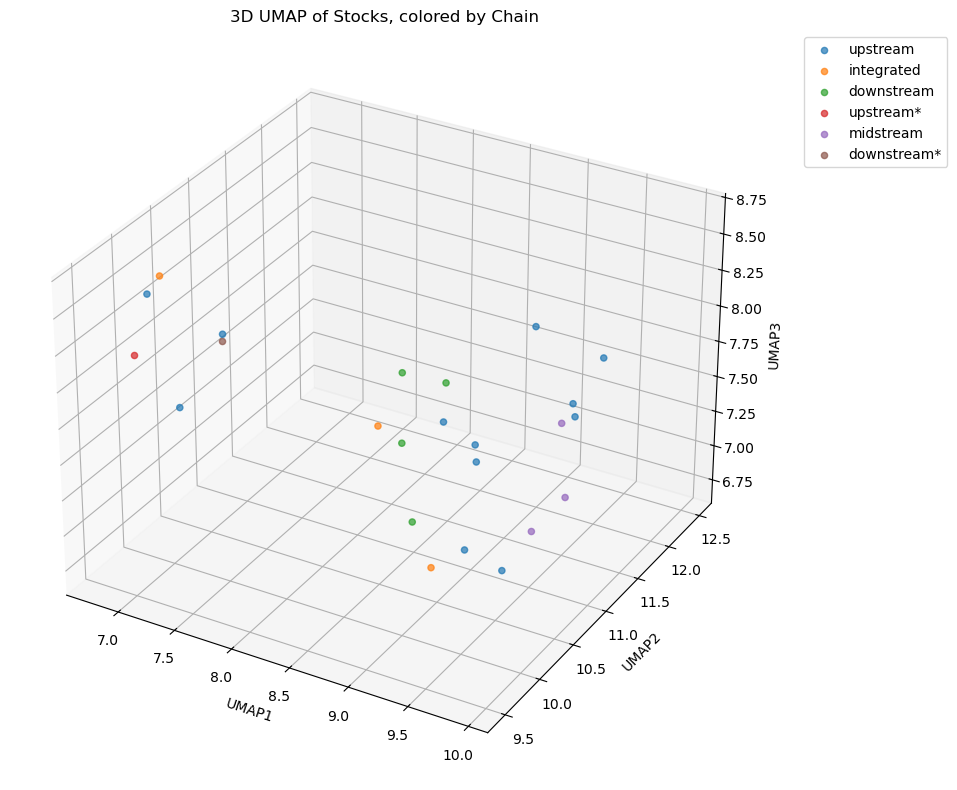

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from adjustText import adjust_text
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# 1) Compute a 3D UMAP embedding
umapper3d = umap.UMAP(
    n_components=3,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1
)
coords3d = umapper3d.fit_transform(imp_matrix)

# 2) Build DataFrame
emb3d = pd.DataFrame(coords3d, columns=['UMAP1','UMAP2','UMAP3'])
emb3d['Ticker_Symbol'] = imp_matrix.index
emb3d = emb3d.merge(
    merged[['Ticker_Symbol','chain']],
    on='Ticker_Symbol',
    how='left'
)

# 3) Palette
unique_chains = emb3d['chain'].dropna().unique()
palette = dict(zip(
    unique_chains,
    sns.color_palette('tab10', n_colors=len(unique_chains))
))

# 4) Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# scatter in 3D
for chain in unique_chains:
    sel = emb3d['chain']==chain
    ax.scatter(
        emb3d.loc[sel,'UMAP1'],
        emb3d.loc[sel,'UMAP2'],
        emb3d.loc[sel,'UMAP3'],
        label=chain,
        color=palette[chain],
        s=20,
        alpha=0.7
    )

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('3D UMAP of Stocks, colored by Chain')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


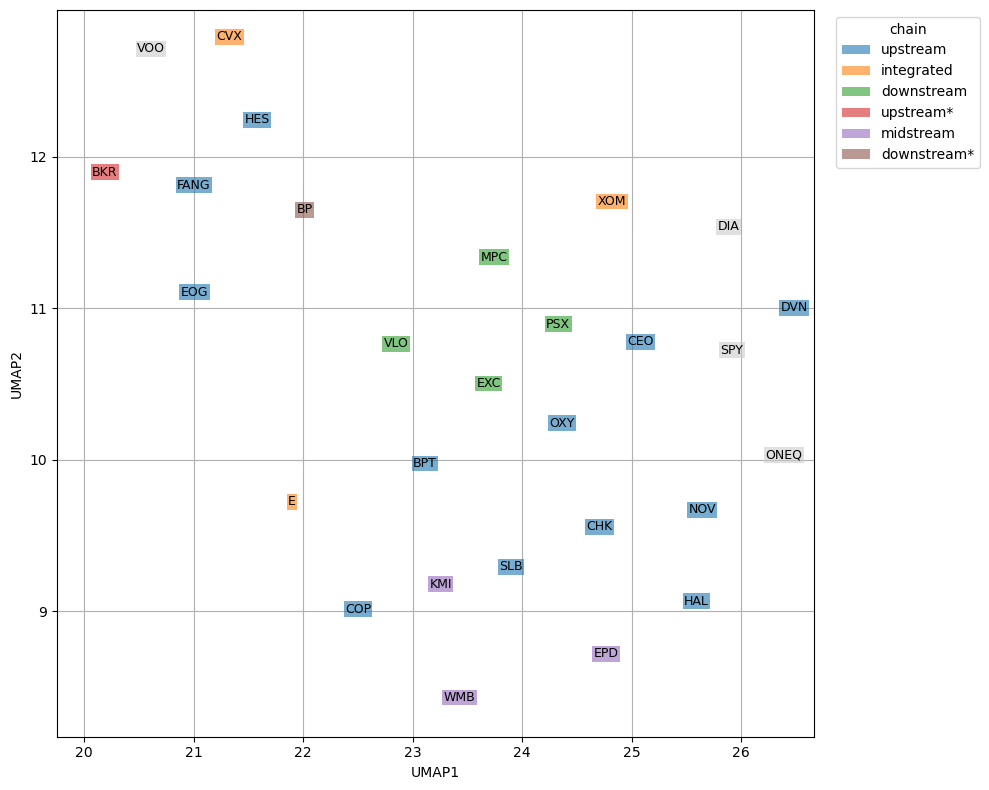

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from adjustText import adjust_text
import umap.umap_ as umap

# 1) Compute UMAP embedding with new params
umapper = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=50,    # larger neighborhood → more global structure
    min_dist=0.5,      # forces points to stay further apart
    metric='cosine',   # cosine distance instead of Euclidean
    spread=1.0,        # how far apart embedded points are allowed to be
    local_connectivity=2  # tightness of the local manifold
)
coords = umapper.fit_transform(imp_matrix)

# 2) Build emb_df
emb_df = pd.DataFrame(
    coords,
    columns=['UMAP1','UMAP2'],
    index=imp_matrix.index
).reset_index().rename(columns={'index':'Ticker_Symbol'})

# 3) Merge in original chain labels
emb_df = emb_df.merge(
    merged[['Ticker_Symbol','chain']],
    on='Ticker_Symbol',
    how='left'
)

# 4) Palette
unique_chains = emb_df['chain'].dropna().unique()
palette = dict(zip(
    unique_chains,
    sns.color_palette('tab10', n_colors=len(unique_chains))
))

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(emb_df['UMAP1'], emb_df['UMAP2'], s=0, alpha=0)

texts = []
for _, row in emb_df.iterrows():
    c = palette.get(row['chain'], (0.8,0.8,0.8))
    txt = ax.text(
        row['UMAP1'], row['UMAP2'], row['Ticker_Symbol'],
        fontsize=9,
        color='black',
        bbox=dict(facecolor=c, alpha=0.6, pad=1, edgecolor='none')
    )
    texts.append(txt)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.grid(True)

legend_handles = [
    Patch(facecolor=col, edgecolor='none', label=chain, alpha=0.6)
    for chain, col in palette.items()
]
ax.legend(handles=legend_handles, title='chain',
          bbox_to_anchor=(1.02,1), loc='upper left')

adjust_text(
    texts,
    only_move={'points':'y','texts':'y'},
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
    ax=ax
)

plt.tight_layout()
plt.show()


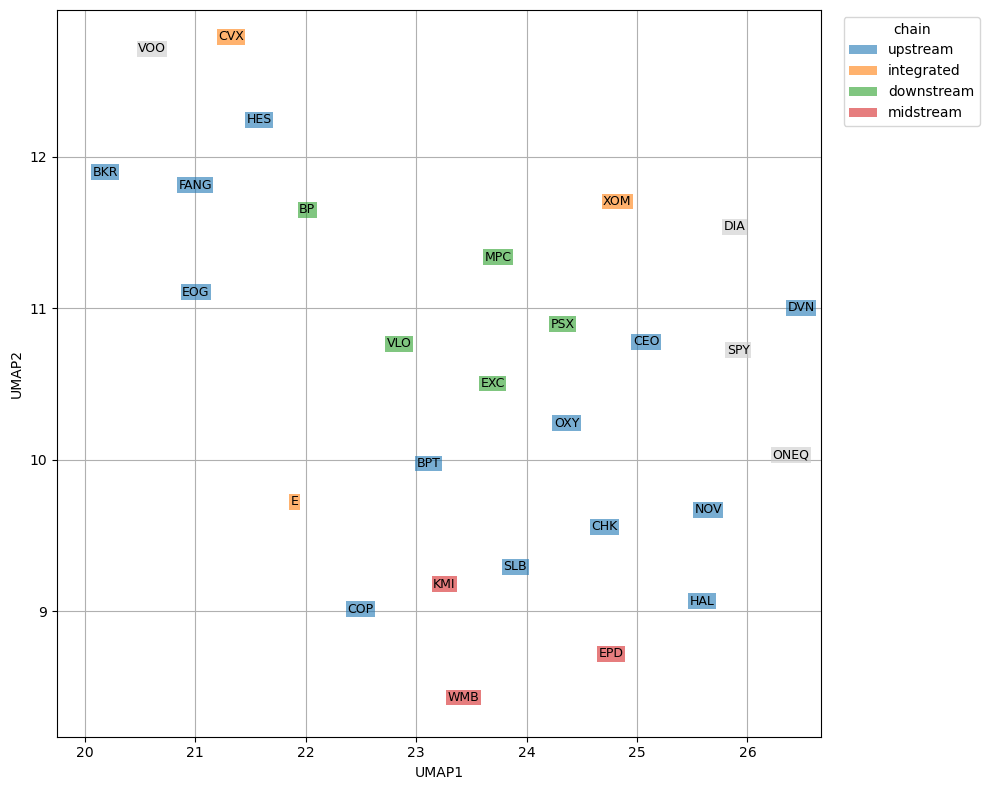

In [88]:
# collapse upstream/downstream variants into 'stream'
collapse_map = {
    'upstream': 'upstream',
    'upstream*': 'upstream',
    'downstream': 'downstream',
    'downstream*': 'downstream'
}
emb_df['chain_collapsed'] = emb_df['chain'].replace(collapse_map)

# build palette on the collapsed column
unique_chains = emb_df['chain_collapsed'].dropna().unique()
palette = dict(zip(
    unique_chains,
    sns.color_palette('tab10', n_colors=len(unique_chains))
))

# plotting
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(emb_df['UMAP1'], emb_df['UMAP2'], s=0, alpha=0)

texts = []
for _, row in emb_df.iterrows():
    color = palette.get(row['chain_collapsed'], (0.8,0.8,0.8))
    txt = ax.text(
        row['UMAP1'], row['UMAP2'], row['Ticker_Symbol'],
        fontsize=9,
        color='black',
        bbox=dict(facecolor=color, alpha=0.6, pad=1, edgecolor='none')
    )
    texts.append(txt)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.grid(True)

legend_handles = [
    Patch(facecolor=col, edgecolor='none', label=chain, alpha=0.6)
    for chain, col in palette.items()
]
ax.legend(handles=legend_handles, title='chain',
          bbox_to_anchor=(1.02,1), loc='upper left')

adjust_text(
    texts,
    only_move={'points':'y','texts':'y'},
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
    ax=ax
)

plt.tight_layout()
plt.show()


In [85]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.patches import Patch
# from adjustText import adjust_text

# # 0) define your palette
# unique_chains = merged['chain'].dropna().unique()
# palette = dict(zip(
#     unique_chains,
#     sns.color_palette('tab10', n_colors=len(unique_chains))
# ))

# # 1) set up figure
# fig, ax = plt.subplots(figsize=(10, 8))

# # 2) invisible scatter to set limits
# ax.scatter(merged['PC1'], merged['PC2'], s=0, alpha=0)

# # 3) draw labels
# texts = []
# for _, row in merged.iterrows():
#     c = palette.get(row['chain'], (0.8, 0.8, 0.8))
#     txt = ax.text(
#         row['PC1'], row['PC2'], row['Ticker_Symbol'],
#         fontsize=9, color='black',
#         bbox=dict(facecolor=c, alpha=0.6, pad=1, edgecolor='none')
#     )
#     texts.append(txt)

# # 4) axes, title, grid
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_title('PCA of Stocks, labeled by Ticker, colored by Chain')
# ax.grid(True)

# # 5) legend
# legend_handles = [
#     Patch(facecolor=col, edgecolor='none', label=chain, alpha=0.6)
#     for chain, col in palette.items()
# ]
# ax.legend(handles=legend_handles, title='chain',
#           bbox_to_anchor=(1.02, 1), loc='upper left')

# # 6) nudge overlapping text
# adjust_text(
#     texts,
#     only_move={'points': 'y', 'texts': 'y'},
#     arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
#     ax=ax
# )

# plt.tight_layout()
# plt.show()


In [86]:
# # strip off the “*” suffix…
# merged['chain_simple'] = merged['chain'].str.replace(r'\*$', '', regex=True)

# # then merge both upstream/downstream into one “up/down” category
# merged['chain_simple'] = merged['chain_simple'].replace({
#     'upstream':   'up/down',
#     'downstream': 'up/down'
# })

In [87]:
# import seaborn as sns
# from matplotlib.patches import Patch
# from adjustText import adjust_text
# import matplotlib.pyplot as plt

# # unique collapsed categories:
# unique_chains = merged['chain_simple'].dropna().unique()
# palette = dict(zip(
#     unique_chains,
#     sns.color_palette('tab10', n_colors=len(unique_chains))
# ))

# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(merged['PC1'], merged['PC2'], s=0, alpha=0)

# texts = []
# for _, row in merged.iterrows():
#     col = palette.get(row['chain_simple'], (0.8,0.8,0.8))
#     txt = ax.text(
#         row['PC1'], row['PC2'], row['Ticker_Symbol'],
#         fontsize=9, color='black',
#         bbox=dict(facecolor=col, alpha=0.6, pad=1, edgecolor='none')
#     )
#     texts.append(txt)

# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_title('PCA of Stocks, labeled by Ticker, colored by Chain')
# ax.grid(True)

# legend_handles = [
#     Patch(facecolor=col, edgecolor='none', label=chain, alpha=0.6)
#     for chain, col in palette.items()
# ]
# ax.legend(handles=legend_handles, title='chain',
#           bbox_to_anchor=(1.02, 1), loc='upper left')

# adjust_text(
#     texts,
#     only_move={'points':'y', 'texts':'y'},
#     arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
#     ax=ax
# )

# plt.tight_layout()
# plt.show()
